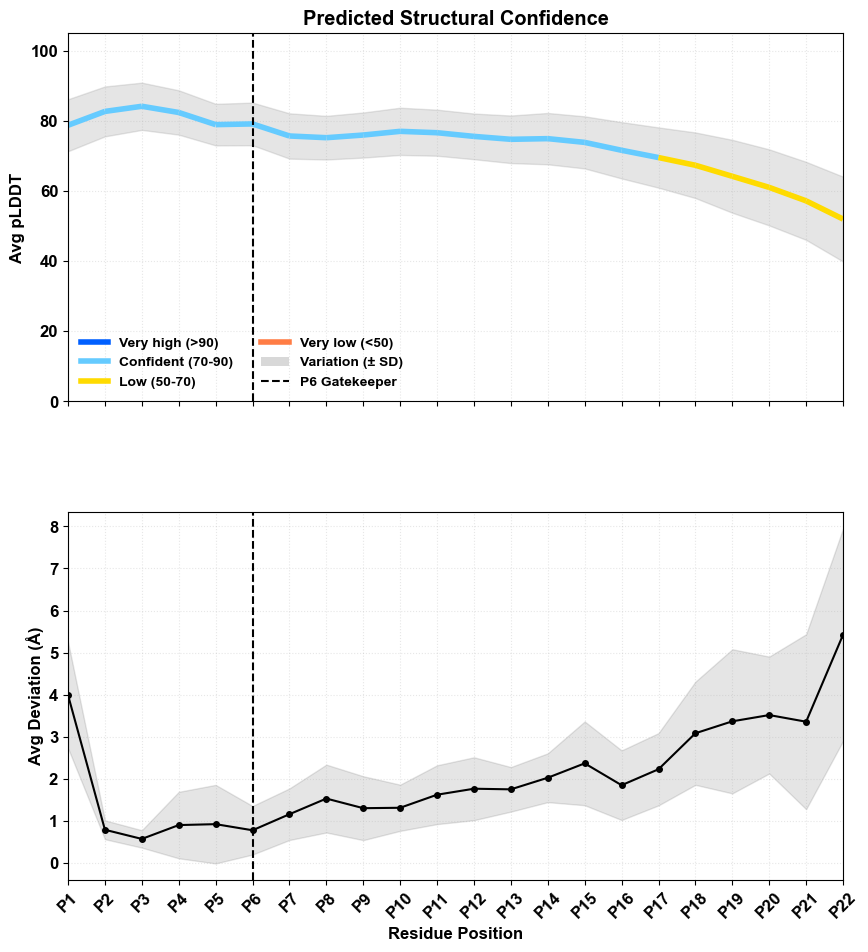

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Configuration
models_dir = "./accepted_models"
distance_csv = "distances.csv"
output_svg = "positional_variation.svg"

# Set global font settings to Arial Bold 12pt
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Liberation Sans'],
    'font.weight': 'bold',
    'font.size': 12,
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold'
})

def get_plddt_from_pdb(pdb_path, position_from_cterm):
    ca_lines = []
    if not os.path.exists(pdb_path): return np.nan
    with open(pdb_path, 'r') as f:
        for line in f:
            if line.startswith("ATOM") and " CA " in line and line[21:22] == "B":
                ca_lines.append(line)
    if not ca_lines: return np.nan
    target_line = ca_lines[::-1][position_from_cterm - 1]
    return float(target_line[60:66].strip())

# 1. Load and process data
df = pd.read_csv(distance_csv)
df['pLDDT'] = [get_plddt_from_pdb(os.path.join(models_dir, r['Model']), int(r['Position'])) for _, r in df.iterrows()]

# 2. Calculate stats
stats = df.groupby("Position").agg({
    "Distance": ["mean", "std"],
    "pLDDT": ["mean", "std"]
}).reset_index()
stats.columns = ['Position', 'Dist_mean', 'Dist_std', 'pLDDT_mean', 'pLDDT_std']

# 3. Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 11), sharex=True)
plt.subplots_adjust(hspace=0.3)

# --- pLDDT Panel ---
x, y = stats["Position"], stats["pLDDT_mean"]
y_err = stats["pLDDT_std"].fillna(0)

# Error area
ax1.fill_between(x, y - y_err, y + y_err, color='gray', alpha=0.2)

# pLDDT Line
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors = ['#005fff' if v >= 90 else '#65cbff' if v >= 70 else '#ffdb00' if v >= 50 else '#ff7d45' for v in y]
lc = LineCollection(segments, colors=colors, linewidth=4)
ax1.add_collection(lc)

# Gatekeeper transition
ax1.axvline(x=6, color='black', linestyle='--', linewidth=1.5)

ax1.set_xlim(1, 22)
ax1.set_ylim(0, 105)
ax1.set_ylabel("Avg pLDDT")
ax1.set_title("Predicted Structural Confidence")

# Expanded Legend
legend_elements = [
    Line2D([0], [0], color='#005fff', lw=4, label='Very high (>90)'),
    Line2D([0], [0], color='#65cbff', lw=4, label='Confident (70-90)'),
    Line2D([0], [0], color='#ffdb00', lw=4, label='Low (50-70)'),
    Line2D([0], [0], color='#ff7d45', lw=4, label='Very low (<50)'),
    Patch(facecolor='gray', alpha=0.3, label='Variation (± SD)'),
    Line2D([0], [0], color='black', linestyle='--', label='P6 Gatekeeper')
]
ax1.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=False, ncol=2)

# --- Distance Panel ---
dy = stats["Dist_mean"]
dy_err = stats["Dist_std"].fillna(0)

ax2.fill_between(x, dy - dy_err, dy + dy_err, color='black', alpha=0.1)
ax2.plot(x, dy, color='black', marker='o', markersize=4, linewidth=1.5)
ax2.axvline(x=6, color='black', linestyle='--', linewidth=1.5)

ax2.set_ylabel("Avg Deviation (Å)")
ax2.set_xlabel("Residue Position")
ax2.set_xticks(range(1, 23))
ax2.set_xticklabels([f"P{i}" for i in range(1, 23)], rotation=45)

for ax in [ax1, ax2]:
    ax.grid(True, linestyle=':', alpha=0.3)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontweight('bold')

plt.savefig(output_svg, format='svg', transparent=True, bbox_inches='tight')
plt.show()